In [1]:
# # this is to suppress 
# def warn(*args, **kwargs):
#     pass
# import warnings
# warnings.warn = warn

from collections import defaultdict

import numpy as np
from scipy.stats import pearsonr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import clone
from sklearn.linear_model import LassoCV
from sklearn.metrics import (mean_squared_error as mse,
                             mean_squared_log_error as msle,
                             mean_absolute_error as mae,
                             r2_score)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import RandomForestRegressor

# package imports
from plot_utils import (plot_regressor_output, compare_model_performance,
                        plot_residual_distribution, plot_monthly_finance_distributions,
                        plot_week_over_week_transactions, plot_features_correlation,
                        visualize_finances, plot_transaction_type_dist,
                        plot_feature_importance)

from load_transform import load_transform_dataset
from features import compute_feature_vectors
from custom_metrics import preciness


from IPython.display import display, HTML, Image

%matplotlib notebook
sns.set_style('whitegrid')

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

## Dataset Load & Transform
---
todo

In [2]:
np.random.seed(42)
ds, user_finances = load_transform_dataset('2016-09-19_79351_training.csv')

# Setting some useful vars
months = ['February', 'March', 'April', 'May', 'June', 'July']
days   = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

## Explore Dataset
---
todo

<IPython.core.display.Javascript object>


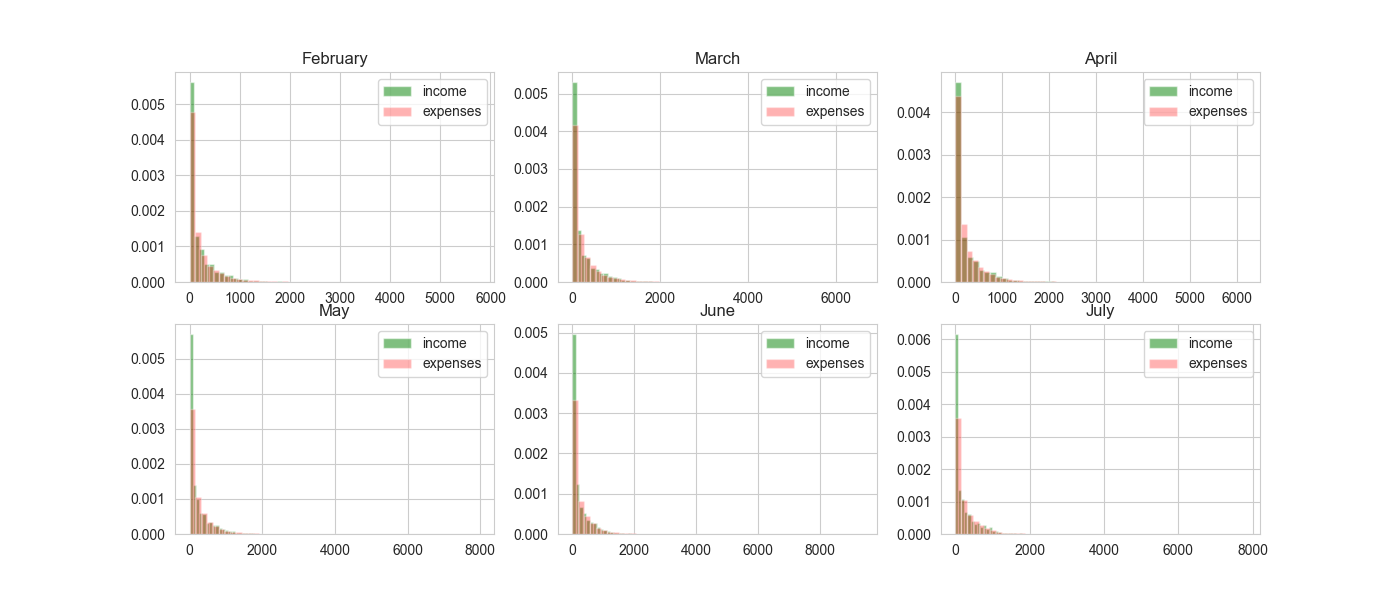

In [3]:
plot_monthly_finance_distributions(user_finances, 'in', 'out', 'income', 'expenses', log_transform=False)

<IPython.core.display.Javascript object>


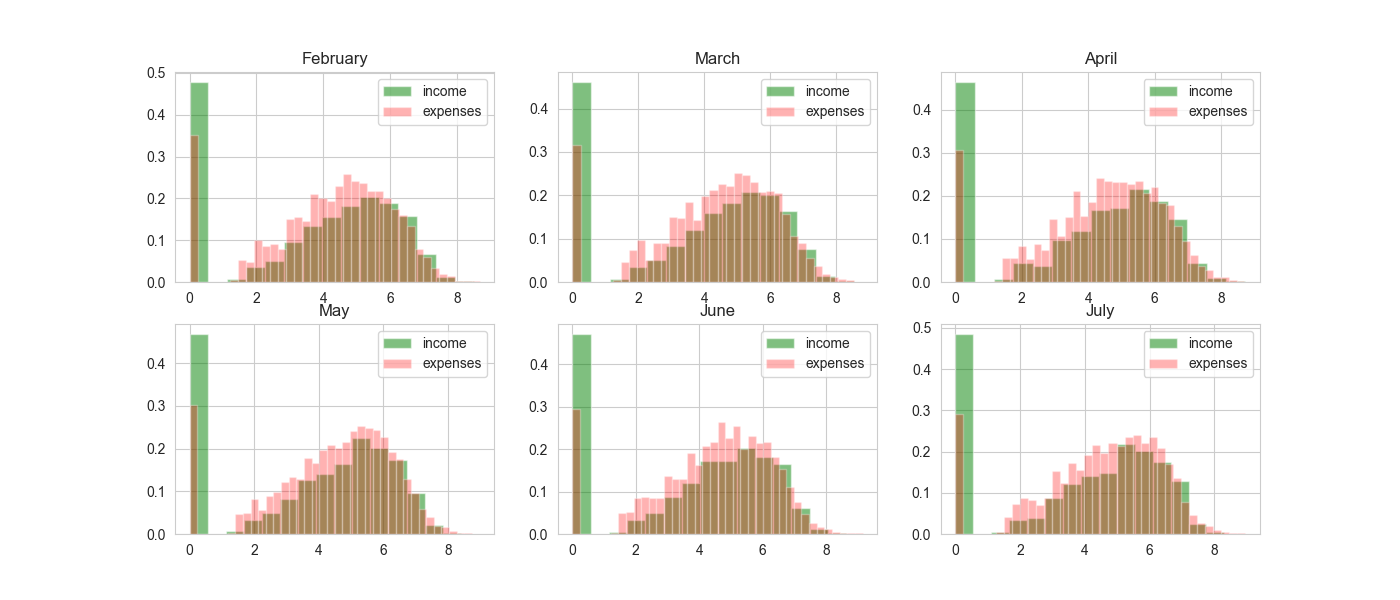

In [4]:
plot_monthly_finance_distributions(user_finances, 'In', 'out', 'income', 'expenses', log_transform=True)

<IPython.core.display.Javascript object>


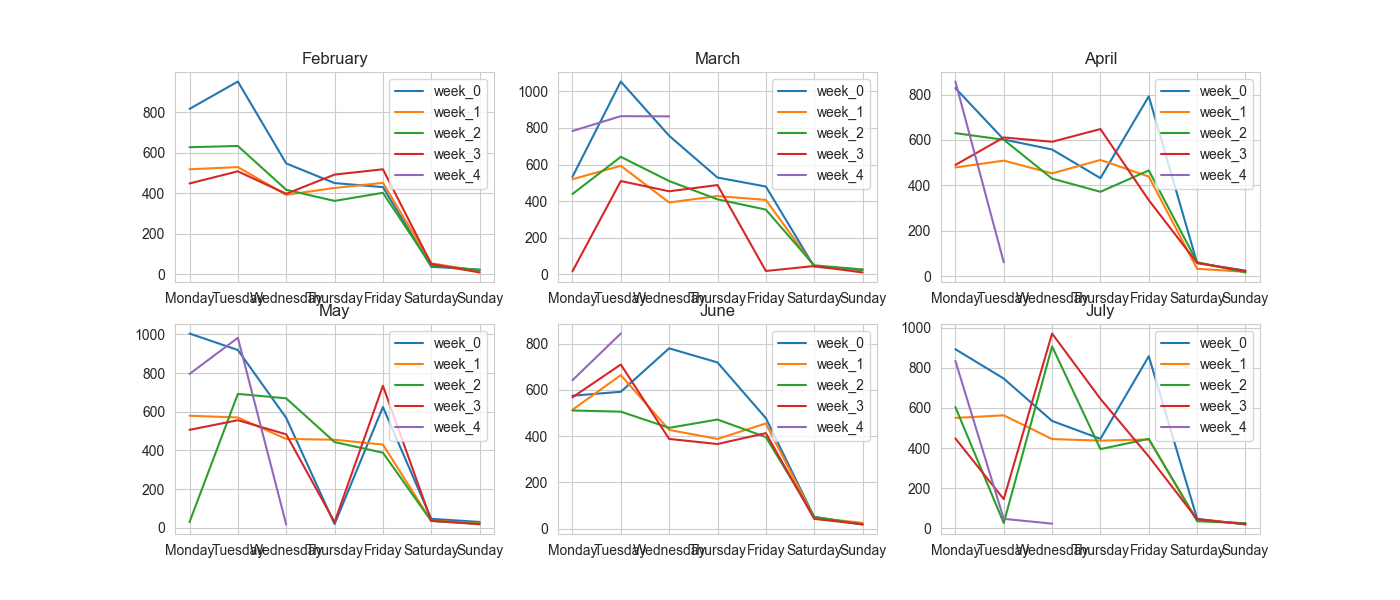

In [6]:
plot_week_over_week_transactions(ds, direction='In', transaction_type=None)

<IPython.core.display.Javascript object>


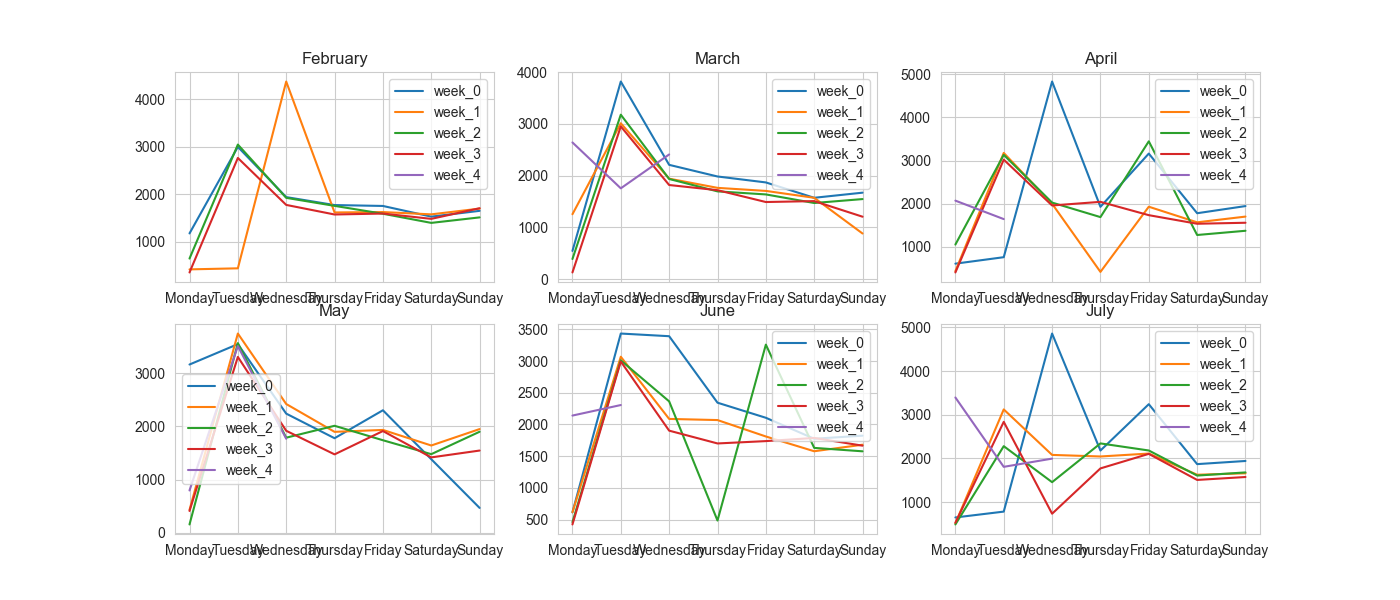

In [7]:
plot_week_over_week_transactions(ds, direction='Out')

<IPython.core.display.Javascript object>


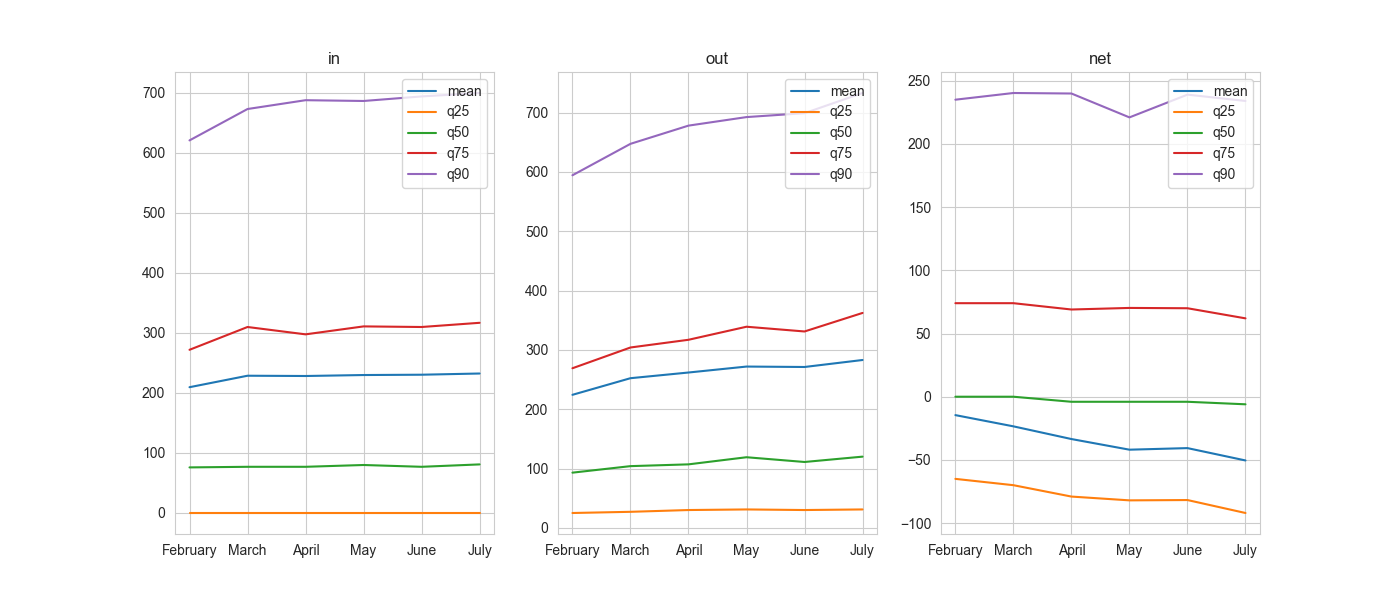

In [8]:
visualize_finances(user_finances)

<IPython.core.display.Javascript object>


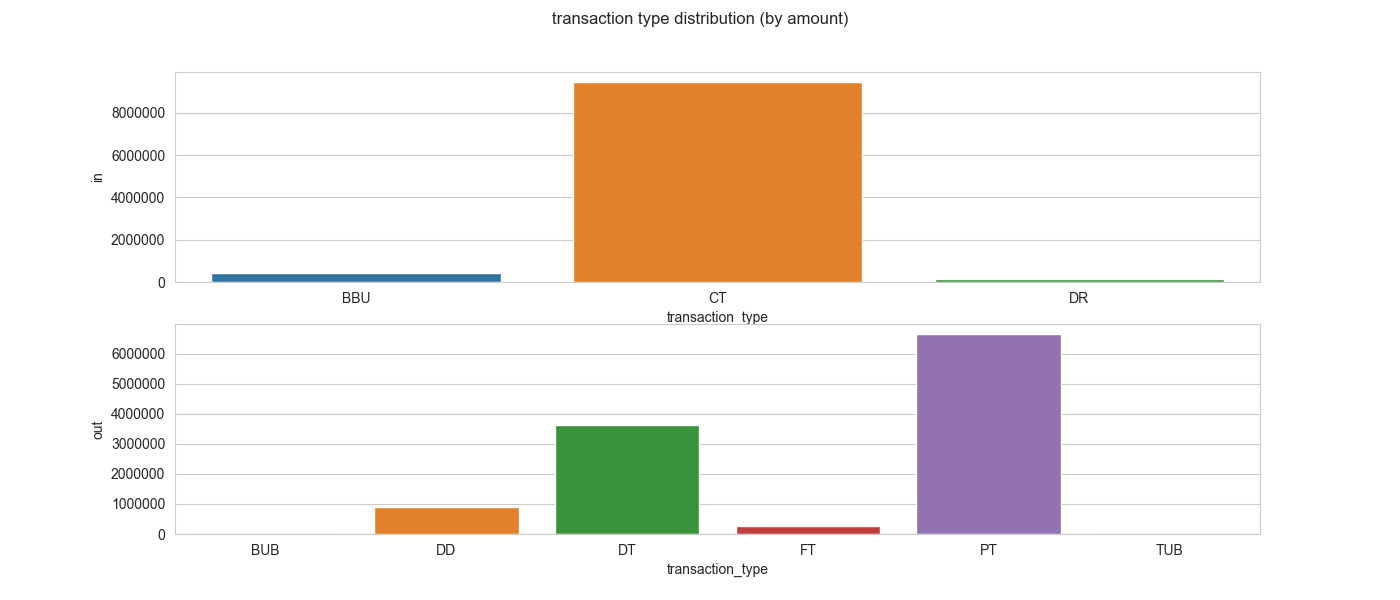

In [9]:
plot_transaction_type_dist(ds, amount=True)

<IPython.core.display.Javascript object>


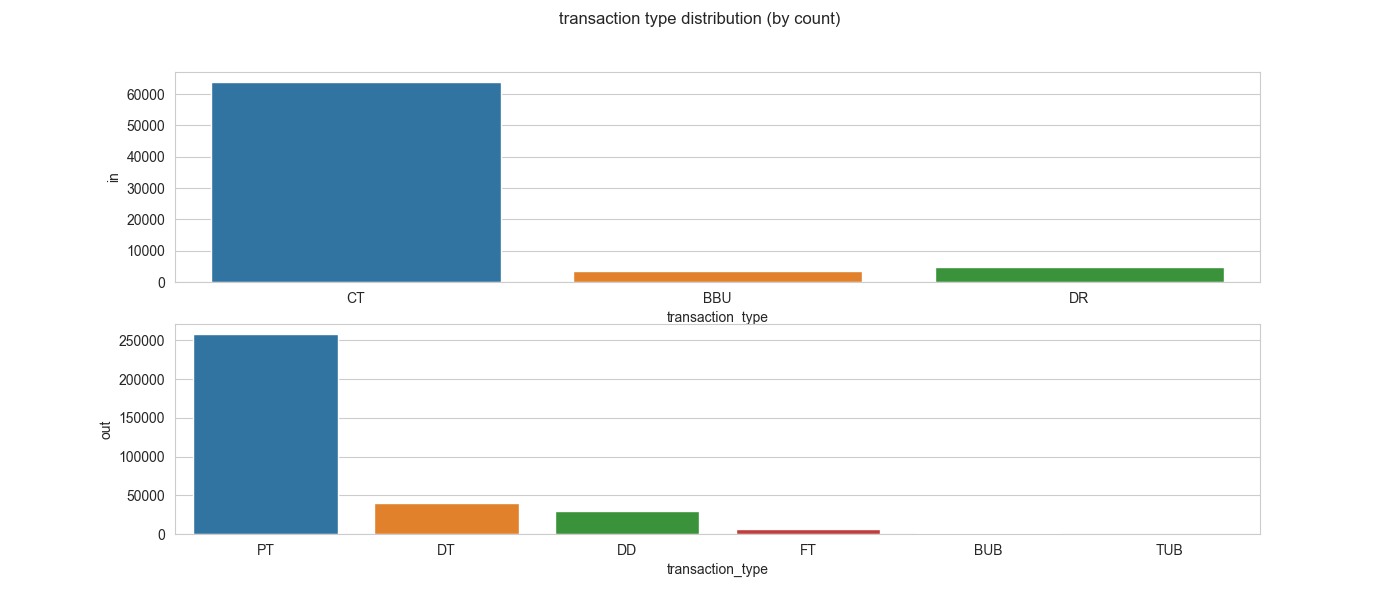

In [10]:
plot_transaction_type_dist(ds, amount=False)

## Feature Creation
----
todo

In [11]:
feature_vectors, feature_name = compute_feature_vectors(ds)

<IPython.core.display.Javascript object>


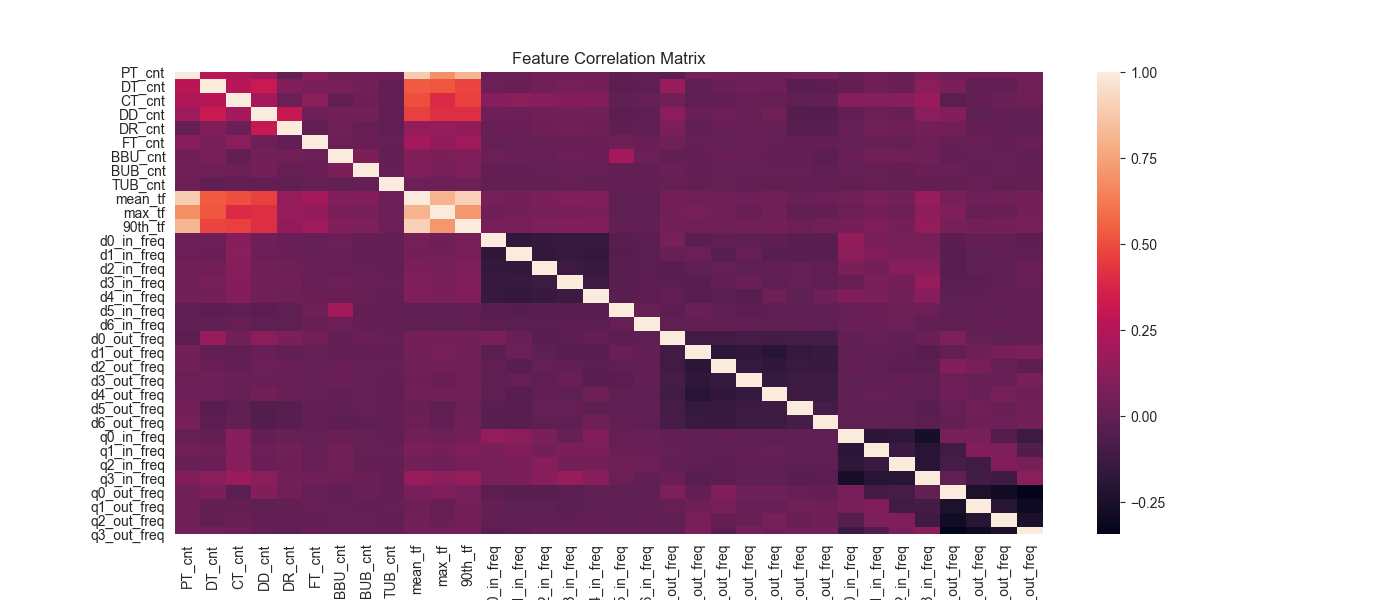

In [12]:
plot_features_correlation(feature_vectors, feature_name)

## Model Training & Evaluation
---
todo

In [13]:
# Those are the different models we will train and compare
classifiers = {
    # our baseline predictor will be the median of the training set
    'baseline': None,
    # Decision Tree regressor works by splitting nodes based on MSE and averaging the values of the leaf nodes for the output.
    # The decision to transform the target needs more attention, since here the averaging happens on the log-transfomed var.
    # Validation showed better performance but it needs further review. 
    'RF': TransformedTargetRegressor(
        regressor=RandomForestRegressor(n_estimators=400, max_depth=10, max_features=10, min_samples_leaf=4, random_state=42),
        func=np.log1p, inverse_func=np.expm1
    ),
    # Lassso Regression is an L1 reqularised OLS regression. It allows for weights to become zero and not affect the outcome.
    # Here we extend the existing features with their 2-degree polynomial combinations. Leads to better fitting and generalization.
    # A standard scaler has been used to center the feature values as well as a transformation on the target var to give it a
    # normal-like probability distribution.
    'Lasso': make_pipeline(
        PolynomialFeatures(2),
        StandardScaler(),
        TransformedTargetRegressor(
            regressor=LassoCV(random_state=42, max_iter=1e3),
            func=np.log1p, inverse_func=np.expm1),
    ),
}

In [ ]:
# Auxiliary functions for the training iterations
def split_dataset(user_finances, month, holdout_users):
    """explain splitting explain removal of zeros
    """
    train = user_finances[(user_finances.month != month) & ~user_finances.user_id.isin(holdout_users)]
    val = user_finances[(user_finances.month == month) & ~user_finances.user_id.isin(holdout_users)]
    test = user_finances[(user_finances.month == month) & user_finances.user_id.isin(holdout_users)]

    train_in, train_out = train[train['in'] != 0], train[train['out'] != 0]
    val_in, val_out = val[val['in'] != 0], val[val['out'] != 0]
    test_in, test_out = test[test['in'] != 0], test[test['out'] != 0]
    return train_in, train_out, val_in, val_out, test_in, test_out


def get_X_y(ds, feature_vectors, direction):
    X = []
    for m, u in zip(ds.month.values, ds.user_id.values):
        X.append(feature_vectors[m][u])
    return np.array(X), ds[direction].values

In [ ]:
# holdout sample of users for validation
holdout_users = set(np.random.choice(user_finances.user_id.unique(), size=1000, replace=False))

rmse = lambda y_t, y_p: np.sqrt(mse(y_t, y_p))
rmsle = lambda y_t, y_p: np.sqrt(msle(y_t, y_p))

# LOO (leave one-month-out approach)
classifiers_perf = {
    classifier: {
        month: {
            'in':  {'train': {}, 'validation': {}, 'holdout': {}, 'model': None},
            'out': {'train': {}, 'validation': {}, 'holdout': {}, 'model': None},
        } for month in months
    } for classifier in classifiers.keys()
}


for month in months:
    _user_finances = user_finances.copy()
    train_in, train_out, val_in, val_out, test_in, test_out = split_dataset(_user_finances, month, holdout_users)
    
    X_train_in, y_train_in = get_X_y(train_in, feature_vectors, 'in')
    X_train_out, y_train_out = get_X_y(train_out, feature_vectors, 'out')
    
    X_val_in, y_val_in = get_X_y(val_in, feature_vectors, 'in')
    X_val_out, y_val_out = get_X_y(val_out, feature_vectors, 'out')
    
    X_test_in, y_test_in = get_X_y(test_in, feature_vectors, 'in')
    X_test_out, y_test_out = get_X_y(test_out, feature_vectors, 'out')
    
    for name, clf in classifiers.items():
        if name != 'baseline':
            clf_in, clf_out = clone(clf), clone(clf)
            clf_in.fit(X_train_in, y_train_in)
            clf_out.fit(X_train_out, y_train_out)
            
        for k, features_in, target_in, features_out, target_out in [
            ('train', X_train_in, y_train_in, X_train_out, y_train_out),
            ('validation', X_val_in, y_val_in, X_val_out, y_val_out),
            ('holdout', X_test_in, y_test_in, X_test_out, y_test_out),
        ]:
            if name == 'baseline':
                y_predict_in = np.full(target_in.shape, np.median(y_train_in))
                y_predict_out = np.full(target_out.shape, np.median(y_train_out))
            else:
                y_predict_in = np.maximum(clf_in.predict(features_in), np.zeros(features_in.shape[0]))
                y_predict_out = np.maximum(clf_out.predict(features_out), np.zeros(features_out.shape[0]))
                
            if month == 'July' and k == 'validation' and name != 'baseline':
                plot_regressor_output(target_in, y_predict_in, '{}_income_model'.format(name))
                plot_regressor_output(target_out, y_predict_out, '{}_expenses_model'.format(name))

            for metric, func in [
                ('rmse', rmse), ('rmsle', rmsle), ('r2', r2_score), ('mae', mae), ('preciseness', preciness)
            ]:
                classifiers_perf[name][month]['in'][k][metric] = func(target_in, y_predict_in)
                classifiers_perf[name][month]['out'][k][metric] = func(target_out, y_predict_out)

            classifiers_perf[name][month]['in'][k]['residuals'] = target_in - y_predict_in
            classifiers_perf[name][month]['out'][k]['residuals'] = target_out - y_predict_out
            
            # storing the models for later use
            if name != 'baseline':
                classifiers_perf[name][month]['in']['model'] = clf_in
                classifiers_perf[name][month]['out']['model'] = clf_out
                

### Model Evaluation
---

We use a set of different metrics to evaluate the performance of our model. Those metrics constitute a low-level evaluation influenced by the peculiarities of our data and problem at hand. A more in depth evaluation of our model according to the business goal will take place on the next steps.  
* **RMSE** Useful given that our data is skewed towards small values. In case our classifier overfits to small values this metric will penalize it heavily
* **RMSLE** Penalizes bigger mistakes less when both predicted and true value are big. Useful property for the context of income/expenses prediction. RMSLE also penalizes underestimates more than overestimates. This can also be useful given that our models tend to underestimate high values
* **R2** TODO
* **MAE** To give us an intuitive sense of the size of our errors
* **PRECISENESS** Custom metric that measures the percentage of time our predicted value was close by X percent to our target value. That means that higher values get a relaxed threshold.  

In [ ]:
compare_model_performance('rmse', classifiers_perf)

In [ ]:
compare_model_performance('rmsle', classifiers_perf)

In [ ]:
compare_model_performance('r2', classifiers_perf)

In [ ]:
plot_feature_importance(
    classifiers_perf['RF']['February']['in']['model'].regressor_.feature_importances_,
    feature_names, 'June - Income Predictor'
)

In [ ]:
plot_feature_importance(
    classifiers_perf['RF']['February']['out']['model'].regressor_.feature_importances_,
    feature_names, 'June - Income Predictor'
)

In [ ]:
plot_residual_distribution(classifiers_perf, 'in')

In [ ]:
plot_residual_distribution(classifiers_perf, 'out')

### Store model for use on the evaluation notebook
---
The stored model will correspond to 

## Evaluate model on Holdout Dataset

In [ ]:
# using the RandomForest model that was trained on months Feb-June
income_predictor = classifiers_perf['rf']['June']['in']['model']
expenses_predictor = classifiers_perf['rf']['June']['out']['model']


def evaluate_algorithm(income_predictor, expenses_predictor, ds=None):
    # XXX: test this
    if isinstance(ds, str):
        if dataset.endswith('.csv'):
            ds = pd.read_csv(ds)
            ds = transform_dataset(ds)
    # creating the dataset with target vars. The targets are the aggregated
    # incoming and outgoing amounts for each user each month
    user_finances, _, _ = create_income_expenses_df(ds)
    
    # log transforming the target vars to mitigate skewed distribution
    user_finances['in'] = user_finances.copy()['in'].apply(lambda f: np.log1p(f))
    user_finances['out'] = user_finances.copy()['out'].apply(lambda f: np.log1p(f))
    
    feature_vectors = compute_feature_vectors(ds)
    X = []
    for m, u in zip(user_finances.month.values, user_finances.user_id.values):
        X.append(feature_vectors[m][u])
    X = np.array(X)
    
    y_pred_in = income_predictor.predict(X)
    y_pred_out = expenses_predictor.predict(X)
    
    plot_residuals(np.exp(user_finances['in'].values) - 1, np.exp(y_pred_in) - 1)
    plot_residuals(np.exp(user_finances['out'].values) - 1, np.exp(y_pred_out) - 1)

    
    for y_true, y_pred in [(y_pred_in, user_finances['in'].values), (y_pred_out, user_finances['out'].values)]:
        y_true, y_pred = np.exp(y_true) - 1, np.exp(y_pred) - 1
        print(round(mae(y_true, y_pred), 4))
        print(round(rmsle(y_true, y_pred), 4))
        print(round(r2_score(y_true, y_pred), 4))
        print(round(preciness(y_true, y_pred), 4))
        print(finance_status_accuracy(y_true, y_pred))

evaluate_algorithm(income_predictor, expenses_predictor, ds[ds.month == 'July'])